In [15]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#unzip the dataset
!unzip "/content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip" > /dev/null

In [17]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [18]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Test")

In [19]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

249
113


Found 916 files belonging to 4 classes.


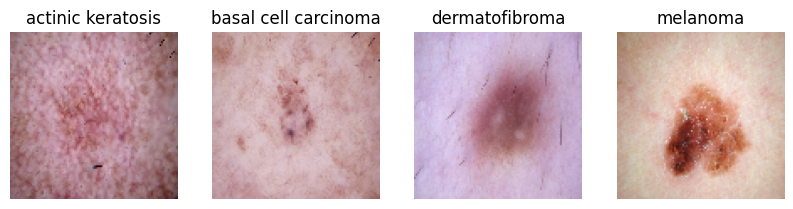

In [49]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(4,4,index)
    plt.imshow(load_img(path_list[0],target_size=(100,100)))
    plt.title(c)
    plt.axis("off")

In [26]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,basal cell carcinoma,376
1,actinic keratosis,114
2,melanoma,331
3,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

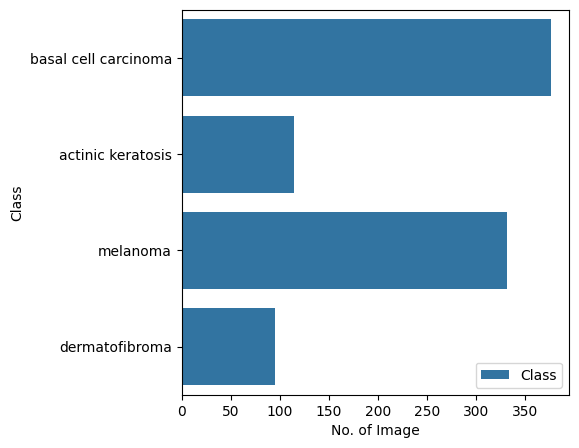

In [28]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [34]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 916 files belonging to 4 classes.
Using 733 files for training.


In [35]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 916 files belonging to 4 classes.
Using 183 files for validation.


In [67]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)
])

In [69]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,BatchNormalization

In [73]:
batch_size = 32  # You can adjust this value based on your system's memory capacity
channels = 3  # Adjust this based on your image data (3 for RGB, 1 for grayscale)
input_shape = (batch_size, img_height, img_width, channels)


In [75]:
# create CNN model

model = Sequential()


model.add(resize_and_rescale)

model.add(data_augmentation)

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))

model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))

model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(32,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dropout(0.10))
n_classes = 2  # Adjust this based on the number of classes in your dataset


model.add(Dense(n_classes))

In [76]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
model.build(input_shape)

In [78]:
# View the summary of all layers
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   multiple                  0         
                                                                 
 sequential_6 (Sequential)   multiple                  0         
                                                                 
 conv2d_103 (Conv2D)         multiple                  896       
                                                                 
 conv2d_104 (Conv2D)         multiple                  18496     
                                                                 
 max_pooling2d_12 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         multiple                  36928     
                                                      

**MODEL TRAINING**

Actual Class: basal cell carcinoma
Predicted Class: class1


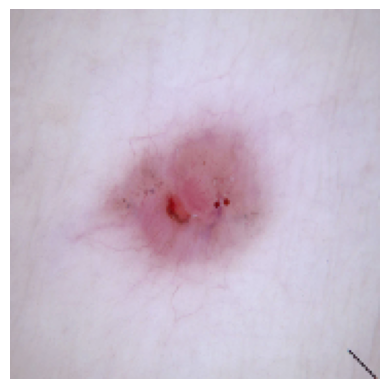

In [48]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
img = image.load_img(image_path, target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
pred_class_name = class_names[predicted_class]

# Print results
print(f"Actual Class: basal cell carcinoma")
print(f"Predicted Class: {pred_class_name}")

img = image.load_img(image_path, target_size=(180, 180))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

